# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Имеются исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


import lightgbm as lgb
from catboost import Pool, CatBoostRegressor, cv

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Приведем названия колонок к стандартному виду.

In [3]:
new_names = {}
for col in data.columns:
    new_names[col] = '_'.join(re.findall('[A-Z][^A-Z]*', col)).lower()
data = data.rename(columns = new_names)
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Посмотрим на явные дубликаты.

In [4]:
data.duplicated().sum()

4

In [5]:
data = data.drop_duplicates()

In [6]:
data.duplicated().sum()

0

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354365 non-null  object
 1   price               354365 non-null  int64 
 2   vehicle_type        316875 non-null  object
 3   registration_year   354365 non-null  int64 
 4   gearbox             334532 non-null  object
 5   power               354365 non-null  int64 
 6   model               334660 non-null  object
 7   kilometer           354365 non-null  int64 
 8   registration_month  354365 non-null  int64 
 9   fuel_type           321470 non-null  object
 10  brand               354365 non-null  object
 11  not_repaired        283211 non-null  object
 12  date_created        354365 non-null  object
 13  number_of_pictures  354365 non-null  int64 
 14  postal_code         354365 non-null  int64 
 15  last_seen           354365 non-null  object
dtypes:

In [8]:
data.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Похоже, что количество фотографий везде равно 0.

In [9]:
data['number_of_pictures'].value_counts()

0    354365
Name: number_of_pictures, dtype: int64

In [10]:
data = data.drop(columns=['number_of_pictures'])

Стоимость автомобиля может зависеть от места продажи. Например, японскую машину лучше всего купить где-нибудь на дальнем востоке. Почтовые индексы тут явно не российские, первый почтовый индекс 70435 может быть в Луизиане, Германии, Литве, Мексике и Украине. Как-то разделить индексы по территориям не получится. Эта колонка не несет полезной информации.

In [11]:
data = data.drop(columns=['postal_code'])

Есть 3 колонки с датами, пока не понятно, будем ли мы их использовать в дальнейшем, но на всякий случай переведем их в формат дата/время.

In [12]:
for col in ['date_crawled','date_created', 'last_seen' ]:
    data[col] = pd.to_datetime(data[col],format='%Y-%m-%d %H:%M:%S')

Посмотрим, когда были выгруженны данные?

In [13]:
data['year_crawled'] = data['date_crawled'].dt.year
data['month_crawled'] = data['date_crawled'].dt.month
data['year_crawled'].value_counts()

2016    354365
Name: year_crawled, dtype: int64

In [14]:
data['month_crawled'].value_counts()

3    296821
4     57544
Name: month_crawled, dtype: int64

Часть данных выгруженна в марте 2016, а часть в апреле. Стоимость автомобиля не должна зависеть от даты выгрузки.

In [15]:
data = data.drop(columns=['year_crawled','date_crawled','month_crawled'])

Посмотрим на даты создания анкет.

In [16]:
data['year_created'] = data['date_created'].dt.year
data['month_created'] = data['date_created'].dt.month
data['year_created'].value_counts()

2016    354339
2015        25
2014         1
Name: year_created, dtype: int64

In [17]:
data['month_created'].value_counts()

3     296756
4      57118
2        397
1         70
11         9
12         9
9          3
8          2
6          1
Name: month_created, dtype: int64

Большинство анкет созданы тогда же, когда и скачаны, в марте и апреле 2016. Вообще стоимость может зависеть от даты размещения, до кризиса одна стоимость, после кризиса другая. 

Посмотрим на последнюю активность поьзователя.

In [18]:
data['year_last_seen'] = data['last_seen'].dt.year
data['month_last_seen'] = data['last_seen'].dt.month
data['year_last_seen'].value_counts()

2016    354365
Name: year_last_seen, dtype: int64

In [19]:
data['month_last_seen'].value_counts()

4    200213
3    154152
Name: month_last_seen, dtype: int64

Похоже, что выгружали завки, где пользователи проявляют активность, скорее всего  эта колонка являлась признаком для выгрузки актуальных данных и не влияет на стоимость автомобиля. Избавимся от неё.

In [20]:
data = data.drop(columns=['year_last_seen','month_last_seen','last_seen'])

Поскольку анкеты скачивались в марте и апреле 2016 года и размещались раньше, то автомобиль не может быть зарегестрирован позже апреля 2016 года. 

In [21]:
data.query('registration_year > 2016')['registration_year'].value_counts()

2017    10441
2018     3959
9999       26
2019       25
5000       17
3000        7
6000        5
2500        4
7000        4
4000        3
9000        3
8000        2
5555        2
2222        2
2800        2
4500        2
5911        2
3700        1
3500        1
2900        1
8500        1
4100        1
9450        1
5900        1
6500        1
7100        1
5300        1
7800        1
8888        1
8200        1
9996        1
8455        1
2290        1
2066        1
5600        1
4800        1
3800        1
3200        1
9229        1
2200        1
7500        1
Name: registration_year, dtype: int64

In [22]:
data.query('registration_year == 2016 &registration_month>4')['registration_month'].value_counts()

6     761
5     707
10    604
7     593
8     548
11    509
9     500
12    468
Name: registration_month, dtype: int64

Удалим эти данные.

In [23]:
data = data.drop(data.query('registration_year > 2016').index)
data = data.drop(data.query('registration_year == 2016 & registration_month>4').index)

Есть какие-то странные значения года регистрации, например в прошлом веке или даже тысячелетии. 

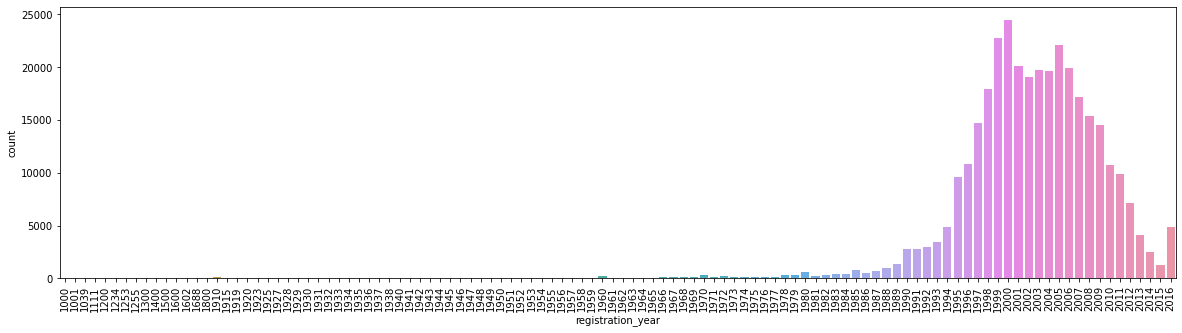

In [24]:
plt.figure(figsize=(20,5))
sns.countplot(data=data,x='registration_year')
plt.xticks(rotation=90)
plt.show()

Даже если и есть старые машины в продаже, то это штучный товар и их цена уже не определяется стандартными параметрами. Отбросим данные до 1985 года. 

In [25]:
data = data.drop(data.query('registration_year < 1985').index)

Посмотрим на пропуски.

In [26]:
data.isna().sum()

price                     0
vehicle_type          17537
registration_year         0
gearbox               16416
power                     0
model                 15857
kilometer                 0
registration_month        0
fuel_type             24241
brand                     0
not_repaired          61071
date_created              0
year_created              0
month_created             0
dtype: int64

Пропусков достаточно много, жалко отбрасывать столько данных, попробуем их заполнить.

Посмотрим на тип кузова.

In [27]:
data['vehicle_type'].value_counts()

sedan          89705
small          79353
wagon          64956
bus            28545
convertible    19578
coupe          15262
suv            11713
other           3048
Name: vehicle_type, dtype: int64

Есть категория с неизвестным типом кузова 'other'. Этим значением и заполним пропуски.

In [28]:
data['vehicle_type'] = data['vehicle_type'].fillna('other')

Посмотрим на тип коробки передач.

In [29]:
data['gearbox'].value_counts()

manual    250602
auto       62679
Name: gearbox, dtype: int64

Это категориальная переменная, обычно их заполняют наиболее часто встречающимся значением. Скорее всего, если бы коробка передач была бы автоматической, то это бы подняло стоимость автомобиля, и владелец бы захотел указать это. Поэтому пропуски заполним ручной коробкой передач.

In [30]:
data['gearbox'] = data['gearbox'].fillna('manual')

В моделях тоже есть значение 'other'. Заполним им пустые значения.

In [31]:
data['model'] = data['model'].fillna('other')

Посмотрим на тип топлива.

In [32]:
data['fuel_type'].value_counts()

petrol      204097
gasoline     95294
lpg           5076
cng            530
hybrid         218
other          153
electric        88
Name: fuel_type, dtype: int64

Тут тоеже заменим пропуски на 'other'

In [33]:
data['fuel_type'] = data['fuel_type'].fillna('other')

Данные по ремонту автомобилей тоже заполним строкой 'other'. Непонятны причины по которым владелец не стал указывать данные о ремонте, а это может повлиять на стоимость автомобиля.

In [34]:
data['not_repaired'] = data['not_repaired'].fillna('other')

Есть много данных со стоимостью автомобиля равной 0. Посмотрим, ошибка ли это или кто-то хочет избавится от ненужного автомобиля и отдает его за бесплатно.

In [35]:
len(data.query('price==0')['price'])/len(data)

0.028289611370440133

In [36]:
len(data.query('price==0')['price'])

9327

С одной стороны ~ 9 тыс. анкет со стоимостью автомобиля равной 0. Это много, чтобы быть случайной ошибкой. А с другой стороны, это всего ~3% от всех данных.

In [37]:
data.query('price==0').head(20)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,year_created,month_created
40,0,other,1990,manual,0,corsa,150000,1,petrol,opel,other,2016-03-26,2016,3
115,0,small,1999,manual,0,other,5000,0,petrol,volkswagen,other,2016-03-20,2016,3
152,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11,2016,3
154,0,other,2006,manual,0,other,5000,0,other,fiat,other,2016-03-22,2016,3
231,0,wagon,2001,manual,115,mondeo,150000,0,other,ford,other,2016-03-16,2016,3
334,0,other,2005,manual,0,polo,150000,0,petrol,volkswagen,other,2016-03-06,2016,3
415,0,other,1985,manual,0,3er,150000,0,other,bmw,other,2016-03-11,2016,3
471,0,other,1990,manual,0,3er,5000,0,other,bmw,other,2016-04-04,2016,4
478,0,other,2000,manual,0,other,150000,0,other,audi,yes,2016-03-24,2016,3
522,0,other,2000,manual,0,other,150000,0,other,volvo,other,2016-03-14,2016,3


Никаких очевидных закономерностей нет. Поскольку мы все-таки прогнозируем не нулевую стоимость автомобиля, то удалим записи, где она равна нулю.

In [38]:
data = data.drop(data.query('price==0').index)

Посмотрим на мощьность двигателя.

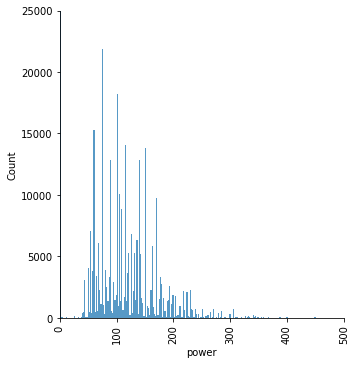

In [39]:
sns.displot(data=data, x="power")
plt.xticks(rotation=90)
plt.xlim(0,500)
plt.ylim(0,25000)
plt.show()

In [40]:
data.query('power>500').head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,year_created,month_created
1816,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22,2016,3
4060,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,2016-04-03,2016,4
5328,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,other,2016-03-29,2016,3
6296,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes,2016-03-31,2016,3
6504,3000,small,2009,manual,771,punto,125000,0,petrol,fiat,other,2016-03-14,2016,3


Вряд ли бывают тойоты кароллы мощностью 1398 л.с. Как пишут в интернете, для машины, чтобы ехать со скоростью 100 км/ч. при идеальной погоде, не считая работы генератора и сопротивления дороги необходим двигатель мощщьностью ~20 л.с. А если взять реальные условия, то мощьность должна быть больше. Отбросим данные с мощьностью больше, чем 350 л.с. и меньше, чем 50 л.с.

In [41]:
data = data.drop(data.query('power<50').index)
data = data.drop(data.query('power>350').index)

Посмотрим на пробег.

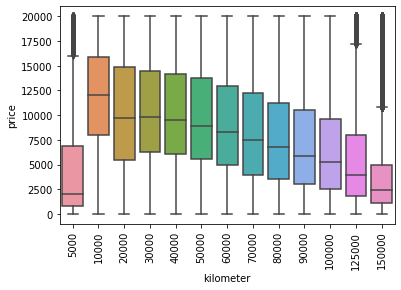

In [42]:
sns.boxplot(data=data, x='kilometer', y='price')
plt.xticks(rotation=90)
plt.show()

Похоже, что с пробегом все в порядке. Чем больше пробег, тем меньше стоимость.

Посмотрим на год и месяц регистрации.

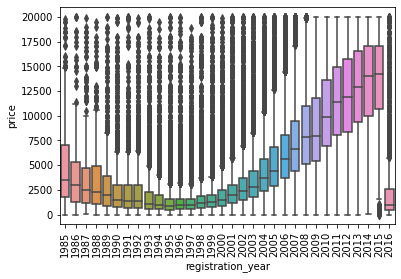

In [43]:
sns.boxplot(data=data, x='registration_year', y='price')
plt.xticks(rotation=90)
plt.show()

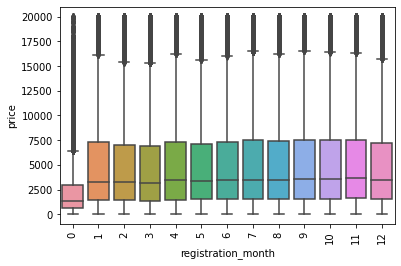

In [44]:
sns.boxplot(data=data,x='registration_month', y='price')
plt.xticks(rotation=90)
plt.show()

От месяца регистрации цена зависит мало.  Я просмотрел все картинки по годам и месяцам, и там тоже от месяца к месяцу цена меняется незначительно. А вот год регистрации имеет значение, поэтому оставим только год, а месяц удалим. 

In [45]:
data = data.drop(columns=['registration_month'])

Посмотрим, как меняется стоимость в зависимости от месяца размещения бъвления.

<AxesSubplot:xlabel='year_created', ylabel='price'>

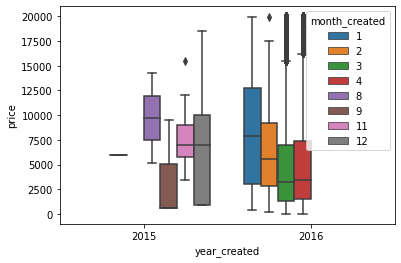

In [46]:
sns.boxplot(data=data, x='year_created', y='price', hue='month_created')

In [47]:
data.query('year_created==2015')['month_created'].value_counts()

12    9
11    8
9     3
8     2
3     1
Name: month_created, dtype: int64

In [48]:
data.query('year_created==2016')['month_created'].value_counts()

3    237645
4     46024
2       337
1        56
Name: month_created, dtype: int64

Все-таки тут месц размещения играет более важную роль, чем месяц регистрации. Видно, что в 2016 году цены на автомобили снижаются. В 2015 году всего одна запись сделана в апреле. Понятно, что если месяц август, сентябрь, ноябрь или декабрь, то год создания объявления 2015, а если январь, февраль, март или апрель, за исключением одной записи, то год 2016. Данные, размещенные в 2014 году удалились раньше.

In [49]:
data = data.drop(columns=['date_created'])
data = data.drop(columns=['year_created'])

### Вывод
В ходе первичной обработки данных была проделана следущая работа:
- Удалены явные дубликаты.
- Удалена колонка с количеством фотографий, поскольку она состояла из нулей.
- Удалена колонка с почтовыми индексами, потому что они не российские и определить по ним регион невозможно.
- Удалена колонка с датой последней активности пользователя, она скорее использовалась для выбора "живых" анкет и не связана со стоимостью автомобиля.
- Удалены аномальные значения года регистрации автомобиля. Анкеты были скачаны в марте и в апреле 2016 года, значит автомобиль не может быть зарегестрирован позже. В прошлом тысячелетии и автомобилей то не было, а если и продаются старинные автомобили, то это штучный товар и их стоимость определяется индивидуально. Ппоэтому были оставлены только данные с 1985 по 2016 год.
- Пропуски почти везде, за исключением типа коробки передач были запонены значением 'other'. В колонке с типом коробки передач пропуски были заполнены на ручной тип, потому что это наиболее часто встречающееся значение, и, автоматическая коробка передач повышает стоимость автомобиля, поэтому владелец бы это указал в объявлении. 
- Были отброшены аномальные значения мощьности. Оставлен интервал от 50 до 350 л.с. в котором содержится большинство данных. 
- Поскольку мы хотим прогнозировать не нулевую стоимость автомобиля, то все анкеты, где стоимость равна 0 были удалены.
- Было показано, что есть взаимосвяз между годом регистрации и стоимостью, а так же пробегом и стоимостью.
- Из информации по размещению объявления был оставлен только месяц, по нему практически однозначно можно восстановить год размещения. В 2015 году мало данных, но в 2016 видно, что цена с начала года падает.

## Обучение моделей

### LightGBM

Как оказалось, строки LightGBM не нравятся. Воспользуемся LabelEncoder, чтобы преобразовать строковые признаки в числовые.

In [50]:
lgb_data = data.copy()
lbl = LabelEncoder()
for col in ['vehicle_type','gearbox','gearbox','model','fuel_type', 'brand', 'not_repaired']:
    lgb_data[col] = lbl.fit_transform(lgb_data[col])
lgb_data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,month_created
1,18300,2,2011,1,190,166,125000,2,1,2,3
2,9800,6,2004,0,163,117,125000,2,14,1,3
3,1500,5,2001,1,75,116,150000,6,38,0,3
4,3600,5,2008,1,69,101,90000,2,31,0,3
5,650,4,1995,1,102,11,150000,6,2,2,4


Выделим целевой параметр в отдельную переменную.

In [51]:
y = lgb_data['price']
X = lgb_data.drop(columns=['price'])

Для обучения LightGBM нужна валидационная выборка. Чтобы проверить модель разделим данные на валидационную и тестовую выборки.

In [52]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

Преобразуем их в подходящий формат для LightGBM.

In [53]:
lgb_train = lgb.Dataset(x_train, y_train, feature_name='auto', categorical_feature=None,free_raw_data=False)

Параметры возбмем как в примере в документации.

In [54]:
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learning_rate': 0.05,
    'metric': 'l2',
    'verbose': -1
}


In [55]:
cv_results = lgb.cv(params, lgb_train, nfold = 3, verbose_eval  = True, metrics = 'rmse')

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	cv_agg's rmse: 4443.23 + 1.51877
[2]	cv_agg's rmse: 4300.3 + 1.60165
[3]	cv_agg's rmse: 4166.75 + 1.63221
[4]	cv_agg's rmse: 4038.84 + 0.847663
[5]	cv_agg's rmse: 3921.98 + 0.941446
[6]	cv_agg's rmse: 3808.85 + 1.93887
[7]	cv_agg's rmse: 3702.04 + 2.19427
[8]	cv_agg's rmse: 3603.61 + 2.61179
[9]	cv_agg's rmse: 3509.75 + 2.06098
[10]	cv_agg's rmse: 3421.8 + 2.21417
[11]	cv_agg's rmse: 3338.33 + 3.21394
[12]	cv_agg's rmse: 3260.11 + 3.88408
[13]	cv_agg's rmse: 3186.54 + 3.53176
[14]	cv_agg's rmse: 3118.6 + 3.67848
[15]	cv_agg's rmse: 3054.15 + 3.10994
[16]	cv_agg's rmse: 2993.74 + 2.34297
[17]	cv_agg's rmse: 2937.39 + 2.557
[18]	cv_agg's rmse: 2884.98 + 2.53653
[19]	cv_agg's rmse: 2835.07 + 2.23184
[20]	cv_agg's rmse: 2787.93 + 3.80311
[21]	cv_agg's rmse: 2742.65 + 4.51491
[22]	cv_agg's rmse: 2700.25 + 3.43204
[23]	cv_agg's rmse: 2660.43 + 4.58119
[24]	cv_agg's rmse: 2621.73 + 4.81507
[25]	cv_agg's rmse: 2586.68 + 5.23116
[26]	cv_agg's rmse: 2553.53 + 4.97643
[27]	cv_agg's rmse: 2521

In [56]:
%%time
model = lgb.train(params,
                 train_set=lgb_train,
                 categorical_feature=['vehicle_type','gearbox','model','fuel_type', 'brand', 'not_repaired'])

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gearbox', 'model', 'not_repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'


CPU times: user 4.86 s, sys: 5.47 ms, total: 4.86 s
Wall time: 4.9 s


 Вынесем предсказание в отдельную ячейку, чтобы оценить время.

In [57]:
%%time
y_pred = model.predict(x_train)

CPU times: user 1.4 s, sys: 232 µs, total: 1.4 s
Wall time: 1.4 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

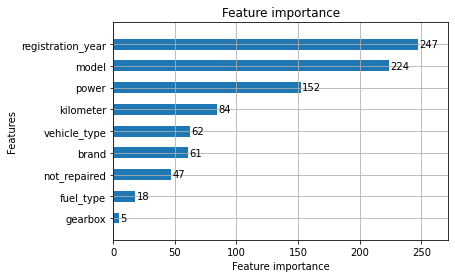

In [58]:
#mse = mean_squared_error(y_test, y_pred)
#rmse = mse**(0.5)
#print("MSE: %.2f" % mse)
#print("RMSE: %.2f" % rmse) 
lgb.plot_importance(model,height=0.5)

In [59]:
performance_dict = {'LGBM':[1860.05, '28.2 s','1.39 s']}
performance_dict

{'LGBM': [1860.05, '28.2 s', '1.39 s']}

RMSE меньше, чем 2500. Можно принимать модель. В задании нужно поменять несколько параметров и посмотреть, как изменится результат.

In [60]:
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'n_estimators': 50,
    'max_depth':10,
    'learning_rate': 0.05,
    'metric': 'l2',
    'verbose': -1
}

In [61]:
cv_results = lgb.cv(params, lgb_train, nfold = 3, verbose_eval  = True, metrics = 'rmse')

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	cv_agg's rmse: 4420.5 + 1.61148
[2]	cv_agg's rmse: 4254.84 + 1.62833
[3]	cv_agg's rmse: 4099.33 + 1.24712
[4]	cv_agg's rmse: 3953.83 + 1.34821
[5]	cv_agg's rmse: 3817.25 + 1.81669
[6]	cv_agg's rmse: 3688.42 + 1.56325
[7]	cv_agg's rmse: 3566.45 + 1.63799
[8]	cv_agg's rmse: 3450.77 + 1.727
[9]	cv_agg's rmse: 3342.27 + 2.53018
[10]	cv_agg's rmse: 3239.95 + 3.03697
[11]	cv_agg's rmse: 3143.42 + 3.53584
[12]	cv_agg's rmse: 3052.76 + 3.13353
[13]	cv_agg's rmse: 2967.54 + 3.72793
[14]	cv_agg's rmse: 2888.11 + 3.25434
[15]	cv_agg's rmse: 2811.88 + 4.20281
[16]	cv_agg's rmse: 2740.73 + 4.29888
[17]	cv_agg's rmse: 2674.21 + 4.79575
[18]	cv_agg's rmse: 2609.74 + 4.76615
[19]	cv_agg's rmse: 2551.24 + 5.35624
[20]	cv_agg's rmse: 2495.39 + 4.84868
[21]	cv_agg's rmse: 2443.53 + 5.08907
[22]	cv_agg's rmse: 2393.99 + 4.91962
[23]	cv_agg's rmse: 2347.74 + 5.14604
[24]	cv_agg's rmse: 2303.98 + 5.10212
[25]	cv_agg's rmse: 2262.73 + 5.89009
[26]	cv_agg's rmse: 2223.85 + 5.82894
[27]	cv_agg's rmse: 2187

RMSE тоже подходит. Определим врямя обучени и прогноза. Оооочень долго считал.  

In [62]:
%%time
model = lgb.train(params,
                 train_set=lgb_train,
                 categorical_feature=['vehicle_type','gearbox','model','fuel_type', 'brand', 'not_repaired']
                 )

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


CPU times: user 3.49 s, sys: 13.1 ms, total: 3.51 s
Wall time: 3.5 s


In [63]:
%%time
y_pred = model.predict(x_train)

CPU times: user 932 ms, sys: 0 ns, total: 932 ms
Wall time: 908 ms


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

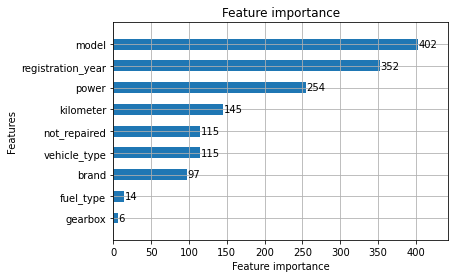

In [64]:
#mse = mean_squared_error(y_test, y_pred)
#rmse = mse**(0.5)
#print("MSE: %.2f" % mse)
#print("RMSE: %.2f" % rmse) 
lgb.plot_importance(model,height=0.5)

In [65]:
performance_dict['LGBM_50_10'] = [1758.67, '1 min 16 s', '1.06 s']
performance_dict

{'LGBM': [1860.05, '28.2 s', '1.39 s'],
 'LGBM_50_10': [1758.67, '1 min 16 s', '1.06 s']}

Уменьшили количество деревьев со 100 до 50 и результат стал хуже, оставим все как было. Интересно, что порядок важности признаков изменился.

In [66]:
del lgb_data
del lgb_train

### Catboost

Раз уж все так хвалят CatBoost, то нужно его попробовать.

In [67]:
cb_data = data.copy()
X = cb_data.drop(columns=['price'])
y = cb_data['price']

In [68]:
x_train, x_test, y_train, y_test_cb = train_test_split(X, y, test_size=0.25,random_state=12345)

In [69]:
train_pool = Pool(x_train, y_train, cat_features=[0,2,4,6,7,8])
test_pool = Pool(x_test,cat_features=[0,2,4,6,7,8]) 

In [70]:
params = {"iterations": 100,
          "depth":10,
          'learning_rate':0.05,
          'loss_function':'RMSE'}

In [71]:
scores = cv(train_pool,
            params,
            fold_count=2, 
            plot="True",
            verbose=False
           )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]

bestTest = 1663.045683
bestIteration = 99

Training on fold [1/2]

bestTest = 1681.920678
bestIteration = 99



In [72]:
model = CatBoostRegressor(logging_level='Silent',loss_function='RMSE')

In [73]:
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'iterations':[30, 70, 100],
        }

In [74]:
grid_search_result = model.grid_search(grid, train_pool, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [75]:
grid_search_result['params']

{'depth': 10, 'iterations': 100, 'learning_rate': 0.1}

Посмотрим сколько модель обучается и предсказывает.


In [76]:
%%time
cb_model = CatBoostRegressor(iterations=100, 
                          depth=10, 
                          learning_rate=0.1, 
                          loss_function='RMSE',
                         logging_level='Silent')

cb_model.fit(train_pool)

CPU times: user 10.7 s, sys: 72.7 ms, total: 10.8 s
Wall time: 11.4 s


In [77]:
%%time
y_pred = cb_model.predict(train_pool)
#mse = mean_squared_error(y_test, y_pred)
#rmse = mse**(0.5)
#print("MSE: %.2f" % mse)
#print("RMSE: %.2f" % rmse) 

CPU times: user 105 ms, sys: 3.92 ms, total: 109 ms
Wall time: 107 ms


In [78]:
performance_dict['CatBoost_100_10'] = [1582.7, '11.4 s','111 ms']
performance_dict

{'LGBM': [1860.05, '28.2 s', '1.39 s'],
 'LGBM_50_10': [1758.67, '1 min 16 s', '1.06 s'],
 'CatBoost_100_10': [1582.7, '11.4 s', '111 ms']}

Попробуем поменять несколько параметров.

In [79]:
#%%time
#model = CatBoostRegressor(iterations=50, 
#                          depth=10, 
#                          learning_rate=0.05, 
#                          loss_function='RMSE')
#
#model.fit(train_pool)

In [80]:
#y_pred = model.predict(train_pool)
#mse = mean_squared_error(y_test, y_pred)
#rmse = mse**(0.5)
#print("MSE: %.2f" % mse)
#print("RMSE: %.2f" % rmse) 

Cтало хуже. Лучше оставим все как было.

In [81]:
#performance_dict['CatBoost_50_10'] = [rmse, '5.81 s']
#performance_dict

###  SGDRegressor

In [82]:
sgd_data = data.copy()
y = sgd_data['price']
X = sgd_data.drop(columns=['price'])

In [83]:
X = OneHotEncoder(drop='first').fit_transform(X)

In [84]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=12345)

Добавим масштабирование.

In [85]:
scaler = StandardScaler(with_mean=False)
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

Попробуем отмасштабировать только численные признаки.

In [86]:
X_num_cat = sgd_data.drop(columns=['price'])
columns_to_scale = ['registration_year','power','kilometer','month_created']
columns_to_encode  = ['vehicle_type', 'gearbox','model','fuel_type', 'brand', 'not_repaired']
scaler = StandardScaler()
ohe    = OneHotEncoder(sparse=False)
scaled_columns  = scaler.fit_transform(X_num_cat[columns_to_scale]) 
encoded_columns =    ohe.fit_transform(X_num_cat[columns_to_encode])
processed_data = np.concatenate([scaled_columns, encoded_columns], axis=1)

In [87]:
x_train_scaled_2, x_test_scaled_2, y_train_2, y_test_2 = train_test_split(processed_data, y, test_size=0.25,random_state=12345)

In [88]:
#%%time
#reg = SGDRegressor(max_iter=1000, tol=1e-3,random_state=12345)
#reg.fit(x_train,y_train)

In [89]:
#y_pred = reg.predict(x_test)
#mse = mean_squared_error(y_test, y_pred)
#rmse = mse**(0.5)
#print("MSE: %.2f" % mse)
#print("RMSE: %.2f" % rmse)  

In [90]:
#performance_dict['SGDR'] = [rmse, '16.4 s']
#performance_dict

Совсем неплохо, быстро и RMSE приемлемое.

Попробуем поиграть с регуляризацией. По умолчанию стоит регуляризация l2. Попробуем другие варианты.

In [91]:
#%%time
#reg = SGDRegressor(max_iter=1000, tol=1e-3,penalty='l1',random_state=12345)
#reg.fit(x_train,y_train)

In [92]:
#y_pred = reg.predict(x_test)
#mse = mean_squared_error(y_test, y_pred)
#rmse = mse**(0.5)
#print("MSE: %.2f" % mse)
#print("RMSE: %.2f" % rmse)  

In [93]:
#performance_dict['SGDR_l1'] = [rmse, '24.1 s']
#performance_dict

In [94]:
#%%time
#reg = SGDRegressor(max_iter=1000, tol=1e-3,penalty='elasticnet',random_state=12345)
#reg.fit(x_train,y_train)

In [95]:
#y_pred = reg.predict(x_test)
#mse = mean_squared_error(y_test, y_pred)
#rmse = mse**(0.5)
#print("MSE: %.2f" % mse)
#print("RMSE: %.2f" % rmse) 

In [96]:
#performance_dict['SGDR_elasticnet'] = [rmse,'22 s']
#performance_dict

Попробуем разные регуляризации через GridSerchCV

In [97]:
reg = SGDRegressor(random_state=12345,max_iter=1000,tol=1e-3)
parameters = {'penalty':['l1','l2','elasticnet'],
             'alpha':[0.0001, 0.1]}

In [98]:
model = GridSearchCV(reg, parameters, scoring='neg_mean_squared_error', cv = 3)
model.fit(x_train,y_train)

GridSearchCV(cv=3, estimator=SGDRegressor(random_state=12345),
             param_grid={'alpha': [0.0001, 0.1],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='neg_mean_squared_error')

In [99]:
model.best_params_

{'alpha': 0.0001, 'penalty': 'l1'}

In [100]:
(-model.best_score_)**0.5

1934.2847507704057

In [101]:
%%time
model = SGDRegressor(random_state=12345,max_iter=1000,tol=1e-3, penalty='l1',alpha=0.0001)
model.fit(x_train,y_train)

CPU times: user 21.3 s, sys: 124 ms, total: 21.4 s
Wall time: 21.4 s


SGDRegressor(penalty='l1', random_state=12345)

In [102]:
%%time
model.predict(x_train)

CPU times: user 5.93 ms, sys: 14 µs, total: 5.94 ms
Wall time: 4.78 ms


array([ 4311.00448337,  6860.98809113, 14191.19926801, ...,
       10903.73531955,  2837.89875142,  5829.0137613 ])

In [103]:
performance_dict['SGDR_l1'] = [1934.28,'22 s','6.54 ms']
performance_dict

{'LGBM': [1860.05, '28.2 s', '1.39 s'],
 'LGBM_50_10': [1758.67, '1 min 16 s', '1.06 s'],
 'CatBoost_100_10': [1582.7, '11.4 s', '111 ms'],
 'SGDR_l1': [1934.28, '22 s', '6.54 ms']}

### Линейная регрессия

In [104]:
%%time
reg = LinearRegression()
reg.fit(x_train, y_train)

CPU times: user 22.1 s, sys: 32.4 s, total: 54.5 s
Wall time: 54.9 s


LinearRegression()

In [105]:
%%time
y_pred = reg.predict(x_train)
#mse = mean_squared_error(y_test, y_pred)
#rmse = mse**(0.5)
#print("MSE: %.2f" % mse)
#print("RMSE: %.2f" % rmse)  

CPU times: user 7.03 ms, sys: 11.7 ms, total: 18.7 ms
Wall time: 5.93 ms


In [106]:
#performance_dict['LinearReg'] = [rmse, '1 min']
#performance_dict

RMSE почти такое же как у градиентного спуска, а обучается значительно дольше.

In [107]:
cvs = cross_val_score(reg, x_train_scaled, y_train, scoring='neg_mean_squared_error',cv=3)
((-cvs)**0.5).mean()

1924.5192248305593

In [108]:
cvs = cross_val_score(reg, x_train, y_train, scoring='neg_mean_squared_error',cv=3)
((-cvs)**0.5).mean()

1924.5286163347607

In [109]:
performance_dict['LinearReg'] = [1942.69, '1 min','48.7 ms']

In [110]:
#cvs = cross_val_score(reg, x_train_scaled_2, y_train_2, scoring='neg_mean_squared_error',cv=3)
#((-cvs)**0.5).mean()

### Случайный лес.

Попробуем случайный лес с такими же параметрами как и CatBoost.

Добавим подбор гиперпараметров в случайный лес.  

In [111]:
reg = RandomForestRegressor(random_state=12345)
parameters = {'n_estimators':[50,100],
                 'max_depth':[5,10]}
model = GridSearchCV(reg, parameters, scoring='neg_mean_squared_error', cv = 2)
model.fit(x_train,y_train)

GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [5, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error')

In [112]:
model.best_params_

{'max_depth': 10, 'n_estimators': 100}

In [113]:
(-model.best_score_)**0.5

2693.2676176881287

In [114]:
%%time
reg = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=12345)
reg.fit(x_train, y_train)

CPU times: user 2min 37s, sys: 0 ns, total: 2min 37s
Wall time: 2min 37s


RandomForestRegressor(max_depth=10, random_state=12345)

Какой он долгий, и это ещё без кроссвалидации и подбора параметров.

In [115]:
%%time
y_pred = reg.predict(x_train)
#mse = mean_squared_error(y_test, y_pred)
#rmse = mse**(0.5)
#print("MSE: %.2f" % mse)
#print("RMSE: %.2f" % rmse)  

CPU times: user 1.1 s, sys: 0 ns, total: 1.1 s
Wall time: 1.11 s


In [116]:
performance_dict['RandForestReg_100_10'] = [2693.27, '3 min 14 s','1 s']
performance_dict

{'LGBM': [1860.05, '28.2 s', '1.39 s'],
 'LGBM_50_10': [1758.67, '1 min 16 s', '1.06 s'],
 'CatBoost_100_10': [1582.7, '11.4 s', '111 ms'],
 'SGDR_l1': [1934.28, '22 s', '6.54 ms'],
 'LinearReg': [1942.69, '1 min', '48.7 ms'],
 'RandForestReg_100_10': [2693.27, '3 min 14 s', '1 s']}

А RMSE не проходит, получилось больше, чем 2500.

## Анализ моделей

In [117]:
pd.DataFrame(performance_dict,index=['rmse','learning_time','prediciton_time']).T.sort_values(by=['rmse'])

,rmse,learning_time,prediciton_time
CatBoost_100_10,1582.7,11.4 s,111 ms
LGBM_50_10,1758.67,1 min 16 s,1.06 s
LGBM,1860.05,28.2 s,1.39 s
SGDR_l1,1934.28,22 s,6.54 ms
LinearReg,1942.69,1 min,48.7 ms
RandForestReg_100_10,2693.27,3 min 14 s,1 s


### Вывод.
- В ходе предварительной обработки было выявленно и отброшено много невалидных данных. Например 1000 год регистрации или год реистрации после даты выгрузки. Аномальные значения мощьности и т.д. Так же были удалены колонки с количеством фотографий, потому что там были нули, почтовый индекс, потому что он не позволяет однозначно определить место продажи, дата выгрузки и дата активности, потому и что она не влияет на стоимость автомобилей.
- Самый лучшей результат показал CatBoost, у него самая низкая RMSE и достаточно быстрое время работы. На втором месте LightGBM, он и хуже считает, и работает медленне, и не работает с категориальными строковыми переменными.
- Хорошо работает линейная регрессия, но она достаточно медленная, а стохастический градиентный спуск работает примерно так же, но в разы быстрее.
- Случайный лес показал самые плохие результаты, RMSE оказалось больше порогового значения и работает он дольше всех.



Берем CatBoost. Он быстрый и точный. Проверим его на тестовой выборке.

In [118]:
y_pred = cb_model.predict(test_pool)
mse = mean_squared_error(y_test_cb, y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)  

MSE: 2552583.45
RMSE: 1597.68
